In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [5]:
measurement_columns = inspector.get_columns('measurement')
for c in measurement_columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [6]:
station_columns = inspector.get_columns('station')
for c in station_columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [7]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

# Exploratory Climate Analysis

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

results = session.query(Measurement.date, Measurement.prcp).all()
end_date = dt.datetime.strptime(results[-1][0], '%Y-%m-%d')

# Calculate the date 1 year ago from the last data point in the database
start_date = end_date - dt.timedelta(days=365)

# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_12_month = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > start_date).all()

In [9]:
last_12_date = [dt.datetime.strptime(date[0], '%Y-%m-%d') for date in last_12_month]
last_12_prcp = [date[1] for date in last_12_month]

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_data = pd.DataFrame({
    'Date': last_12_date,
    'Precipitation': last_12_prcp
})

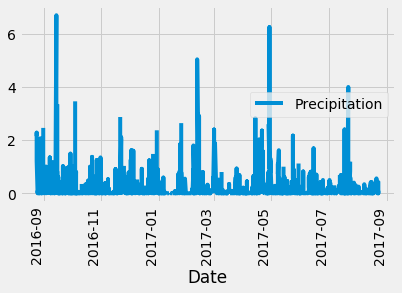

In [10]:
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_data.plot(x='Date', y='Precipitation', rot=90)

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_data.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
station_data = engine.execute('select station from station').fetchall()
station_data

[('USC00519397',),
 ('USC00513117',),
 ('USC00514830',),
 ('USC00517948',),
 ('USC00518838',),
 ('USC00519523',),
 ('USC00519281',),
 ('USC00511918',),
 ('USC00516128',)]

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_counts = engine.execute('select station, count(*) from measurement group by station').fetchall()
station_counts

[('USC00511918', 1979),
 ('USC00513117', 2709),
 ('USC00514830', 2202),
 ('USC00516128', 2612),
 ('USC00517948', 1372),
 ('USC00518838', 511),
 ('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00519523', 2669)]

In [28]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
#engine execute method
station_temps = engine.execute('select station, min(tobs), max(tobs), avg(tobs) from measurement group by station').fetchall()
#session query method
station_temps = session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).group_by(Measurement.station).all()
station_temps

[('USC00511918', 53.0, 87.0, 71.61596766043456),
 ('USC00513117', 59.0, 85.0, 72.68918420081211),
 ('USC00514830', 58.0, 85.0, 74.8732970027248),
 ('USC00516128', 58.0, 84.0, 70.91500765696784),
 ('USC00517948', 58.0, 87.0, 74.68440233236151),
 ('USC00518838', 58.0, 83.0, 72.72407045009784),
 ('USC00519281', 54.0, 85.0, 71.66378066378067),
 ('USC00519397', 56.0, 87.0, 74.55323054331865),
 ('USC00519523', 56.0, 85.0, 74.5436493068565)]

Text(0, 0.5, 'Frequency')

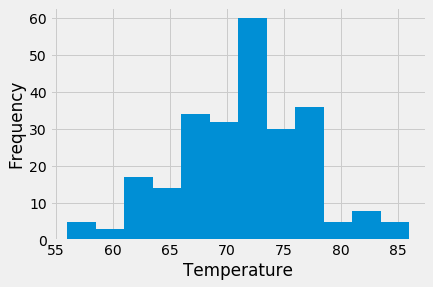

In [74]:
# Choose the station with the highest number of temperature observations.
most_temps = engine.execute(
    'select station, count(*) from measurement group by station limit 1'
).fetchall()[0][0]

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_recent = session.query(Measurement.station, func.max(Measurement.date)).filter(Measurement.station == most_temps).all()[0][1]
most_recent = dt.datetime.strptime(most_recent, '%Y-%m-%d')
start_date = most_recent - dt.timedelta(days=365) 


temps_query = session.query(Measurement.tobs).\
    filter(Measurement.date > start_date).\
    filter(Measurement.station == most_temps).all()

x = [temp[0] for temp in temps_query]

plt.hist(x, bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')

## Bonus Challenge Assignment

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
